In [2]:
%matplotlib inline


Demonstration of load_confounds
============================================



## Background

This notebook is a fork of the <a href="https://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py" target="_blank">"Extracting signals from a brain parcellation"</a> example from Nilearn. From their description: 

> *Here we show how to extract signals from a brain parcellation and compute a correlation matrix.*
> *We also show the importance of **defining good confounds** signals: the first correlation matrix is computed after regressing out simple confounds signals: movement regressors, white matter and CSF signals, ... The second one is without any confounds: all regions are connected to each other.* [Bolded emphasis added]

The data generated by fMRIprep is minimally preprocessed by default. As the Nilearn example demonstrates, only by regressing out confounds are the data made interpretable. 

An issue faced in the literature is how to define good confounds or nuisance variables in a principled and reproducible manner. Preprocessing pipelines such as fMRIPrep may generate a large number of potential confound regressors (100+), with the available regressors depending on initial settings (see <a href="https://fmriprep.org/en/stable/usage.html" target="_blank">"Specific options for estimating confounds"</a>) and variance explained (e.g., CompCor by default includes components that explain 50% of BOLD variance). 

Importantly, it is left to the user to select some combination of confound variables to fully preprocess the time series through denoising (i.e., from the regressors available in the confounds TSV file). There is <a href="https://fmriprep.org/en/stable/outputs.html#confounds" target="_blank">detailed documentation in fMRIPrep</a> about the available confounds and the implications of selecting them, but users are left to (1) decide upon a denoising strategy and (2) implement it by selecting the relevant confounds for regressing out. There can be major repercussions for choosing an inappropriate strategy—note the number of "danger" and "caution" boxes in the aforementioned fMRIPrep documentation on confounds!

The `load_confounds` package addresses those issues by allowing users to choose from predefined and/or flexible strategies, at which point it will automatically select the relevant subset of regressors from the TSV file of all available regressors. If the relevant regressors are not available, the user will be notified. 
- Predefined: The predefined strategies are adapted from <a href="https://doi.org/10.1016/j.neuroimage.2017.03.020">Ciric et al. 2017</a>, and a current list can be viewed on the <a href="https://github.com/SIMEXP/load_confounds#predefined-denoising-strategies" target="_blank">project Github</a>. For example, the predefined strategy `Params6` will select the six basic motion parameters with high pass filter. 
- Flexible: Users can also build a strategy from flexible categories, with a current list available on the <a href="https://github.com/SIMEXP/load_confounds#flexible-denoising-strategy" target="_blank">project Github</a>. For example, the flexible strategy `motion` will select the motion parameters including 6 translation/rotation. Optionally, users can include their derivatives, squares, and squared derivatives. 


## Installation


In [3]:
# install via pip with silent output (unless errors)
!pip install load_confounds > /dev/null

## Retrieve the atlas and the data

In [4]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of brain development fmri data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=False)
fmri_filenames = data.func[0]


Dataset created in /root/nilearn_data/fsl



 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/f46ad01e95960216e8befa3b5c1ed654/HarvardOxford.tgz..... done.


Atlas ROIs are located in nifti image (4D) at: /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz

Dataset created in /root/nilearn_data/development_fmri


Dataset created in /root/nilearn_data/development_fmri/development_fmri



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


## Load confounds from file using a predefined strategy (more automatic)

When given the path to the fMRI filename, the predefined strategies in `load_confounds` will auto-detect the companion TSV file as long as it resides in the same directory.

In [5]:
from load_confounds import Params6

confounds = Params6().load(fmri_filenames)

print(confounds)

[[ 0.00662143 -0.0260775   0.05500607 ...  0.10908987  0.10906602
   0.10903265]
 [ 0.00066804 -0.0275874   0.04945787 ...  0.1089373   0.10872286
   0.10842289]
 [ 0.00662773 -0.0190854   0.07578747 ...  0.10863237  0.10803762
   0.10720679]
 ...
 [-0.00430437  0.05324069 -0.02949963 ...  0.10863237 -0.10803762
   0.10720679]
 [-0.00822667 -0.0815585  -0.03423623 ...  0.1089373  -0.10872286
   0.10842289]
 [-0.02004097  0.0692868  -0.00729393 ...  0.10908987 -0.10906602
   0.10903265]]


## Load confounds from file using a flexible strategy (more manual)

Alternatively, `load_confounds` can be used to create a `Confounds` class which specifies strategies and optional parameters. The `load()` method then selects the relevant columns from the TSV file. 



In [6]:
from load_confounds import Confounds

conf = Confounds(strategy=['motion'], motion="basic")

confounds = conf.load(fmri_filenames)

print(confounds)

[[ 6.62143074e-03 -2.60775002e-02  5.50060690e-02  3.04276666e-04
   5.82586958e-04  2.00935022e-04]
 [ 6.68036743e-04 -2.75874002e-02  4.94578690e-02 -3.15782334e-04
   4.18430958e-04  1.34517022e-04]
 [ 6.62773274e-03 -1.90854002e-02  7.57874690e-02 -2.84531334e-04
   5.94910958e-04  7.58300218e-05]
 ...
 [-4.30437326e-03  5.32406898e-02 -2.94996310e-02 -1.62989334e-04
  -5.74370042e-04  9.10110218e-05]
 [-8.22667326e-03 -8.15585002e-02 -3.42362310e-02  8.56908666e-04
  -5.57425042e-04  4.57440218e-05]
 [-2.00409733e-02  6.92867998e-02 -7.29393416e-03 -4.28001334e-04
  -2.56468042e-04  7.53860218e-05]]


## Extract signals on a parcellation defined by labels

In [7]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(fmri_filenames, confounds=confounds)

[NiftiLabelsMasker.fit_transform] loading data from /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


## Compute and display a correlation matrix



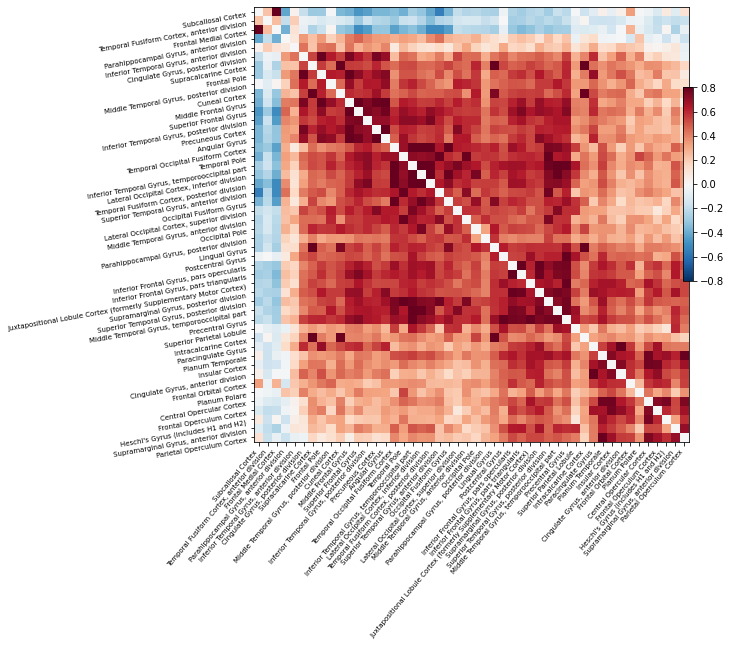

In [8]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)